# A4 Keqi Liao

# Read data

In [34]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
import matplotlib.pyplot as plt
from pyspark.sql.functions import col,sum as spark_sum, count, desc,expr,when
from pyspark.sql.functions import mean
import seaborn as sns
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import percentile_approx

In [16]:
df = spark.read.csv('water_potability.csv', header=True, inferSchema=True)

In [44]:
df.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)



In [4]:
df.show(n=5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|             null| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862|              null| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|8.099124189298397|224.23625939355776|19909.541732292393|9.275883602694089|              n

In [5]:
df.count()

3276

In [6]:
df.summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|         Potability|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|              2785|              3276|              3276|              3276|              2495|              3276|              3276|              3114|              3276|               3276|
|   mean| 7.080794504276819|196.36949601730177| 22014.09252607711| 7.122276793425787| 333.7757766108134| 426.2051106825521|14.284970247677341| 66.39629294676803|3.9667861697910576| 0.3901098901098

# Data visialization

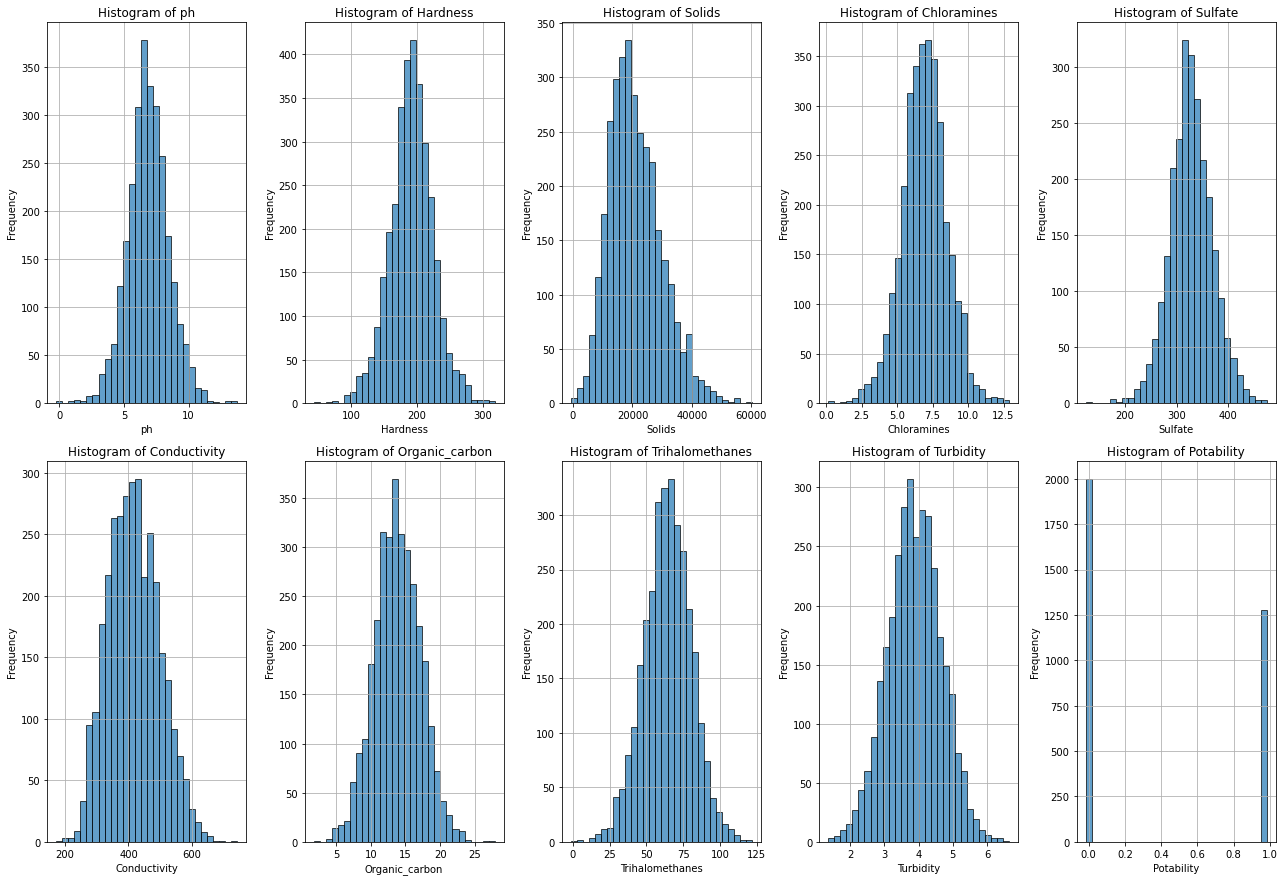

In [23]:
columns_to_plot = [
    'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 
    'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'
]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 18))
axes = axes.flatten()

for idx, column in enumerate(columns_to_plot):

    df_clean = df.select(col(column).cast("float"))

    histogram_data = df_clean.rdd.flatMap(lambda x: x).histogram(30)
    bins = histogram_data[0]
    counts = histogram_data[1]

    axes[idx].bar(bins[:-1], counts, width=bins[1] - bins[0], edgecolor='k', alpha=0.7)
    axes[idx].set_title(f'Histogram of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

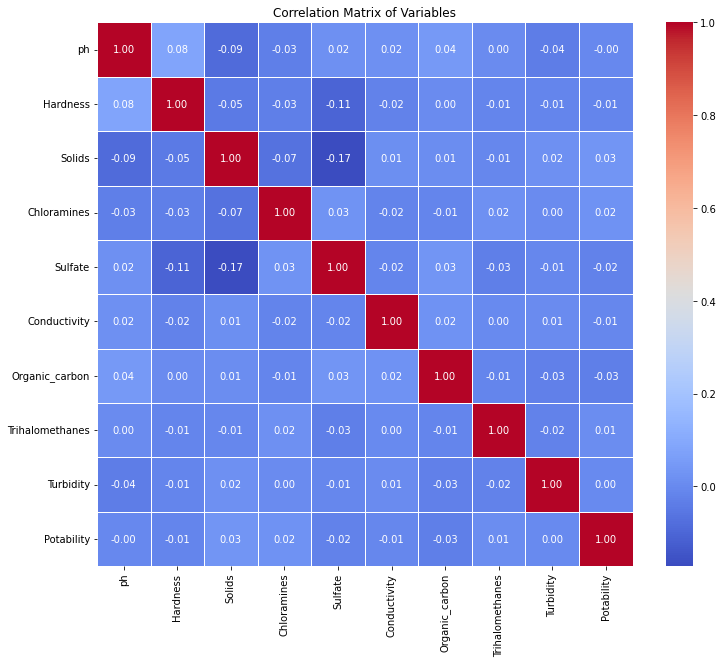

In [24]:
df_clean = df.select([col(column).cast("float") for column in columns_to_plot])

pandas_df = df_clean.toPandas()

correlation_matrix = pandas_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Variables')
plt.show()

# Missing value

In [11]:
# Count missing values in each column
missing_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_plot])

# Show missing counts
missing_counts.show()

# Convert to Pandas DataFrame for better visualization
missing_counts_pd = missing_counts.toPandas()
print(missing_counts_pd)

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|491|       0|     0|          0|    781|           0|             0|            162|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+

    ph  Hardness  Solids  Chloramines  Sulfate  Conductivity  Organic_carbon  \
0  491         0       0            0      781             0               0   

   Trihalomethanes  Turbidity  Potability  
0              162          0           0  


# Outliers

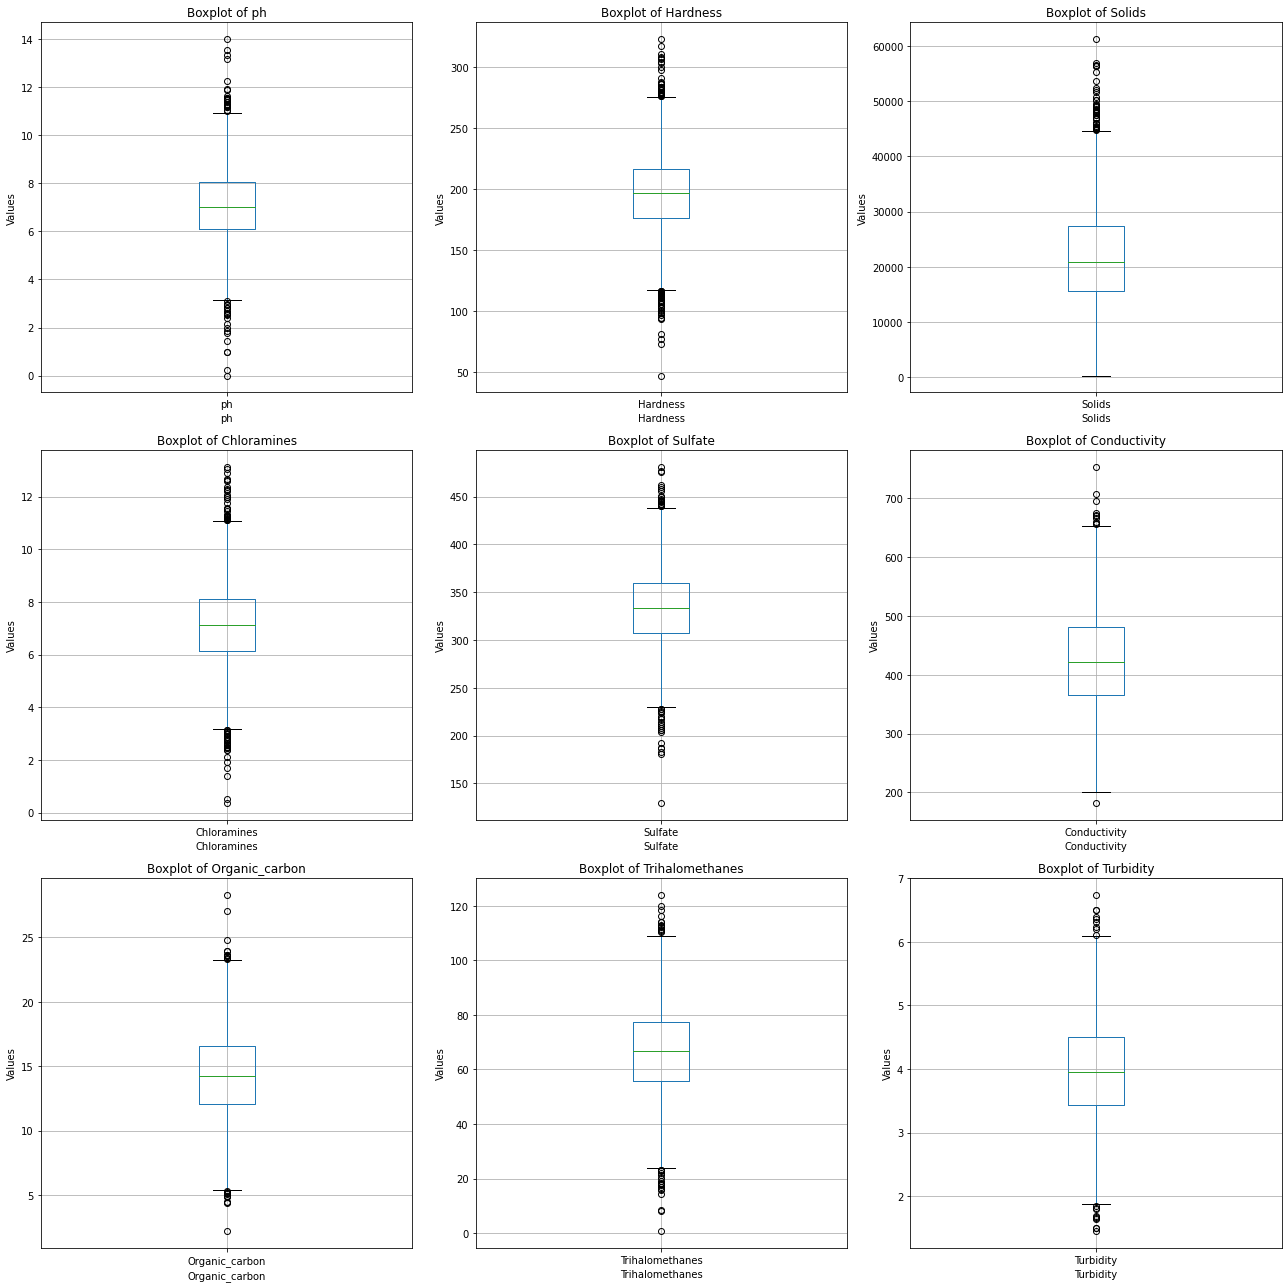

In [56]:
columns_to_plot2 = [
    'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 
    'Organic_carbon', 'Trihalomethanes', 'Turbidity']

df_clean = df.select([col(column).cast("float") for column in columns_to_plot2])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

axes = axes.flatten()

for idx, column in enumerate(columns_to_plot2):
    pandas_df.boxplot(column=column, ax =axes[idx])

    axes[idx].set_title(f'Boxplot of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Values')
    axes[idx].grid(True)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Dealing with missing value

In [46]:
mean_val = df.select(mean(col('Sulfate'))).collect()[0][0]
df_filled = df.na.fill(mean_val, ['Sulfate'])

median_val = df_filled.select(percentile_approx(col('ph'), 0.5).alias('median')).collect()
median = median_val[0][0]
df_filled_2 = df_filled.na.fill(median, ['ph'])

median_val2 = df_filled.select(percentile_approx(col('Trihalomethanes'), 0.5).alias('median')).collect()
median_val2 = median_val2[0][0]
df_filled_3 = df_filled_2.na.fill(median_val2, ['Trihalomethanes'])


+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862| 333.7757766108134| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|8.099124189298397|224.23625939355776|19909.541732292393|9.275883602694089| 333.7757766108

In [48]:
missing_counts = df_filled_3.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_plot])
missing_counts.show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|  0|       0|     0|          0|      0|           0|             0|              0|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



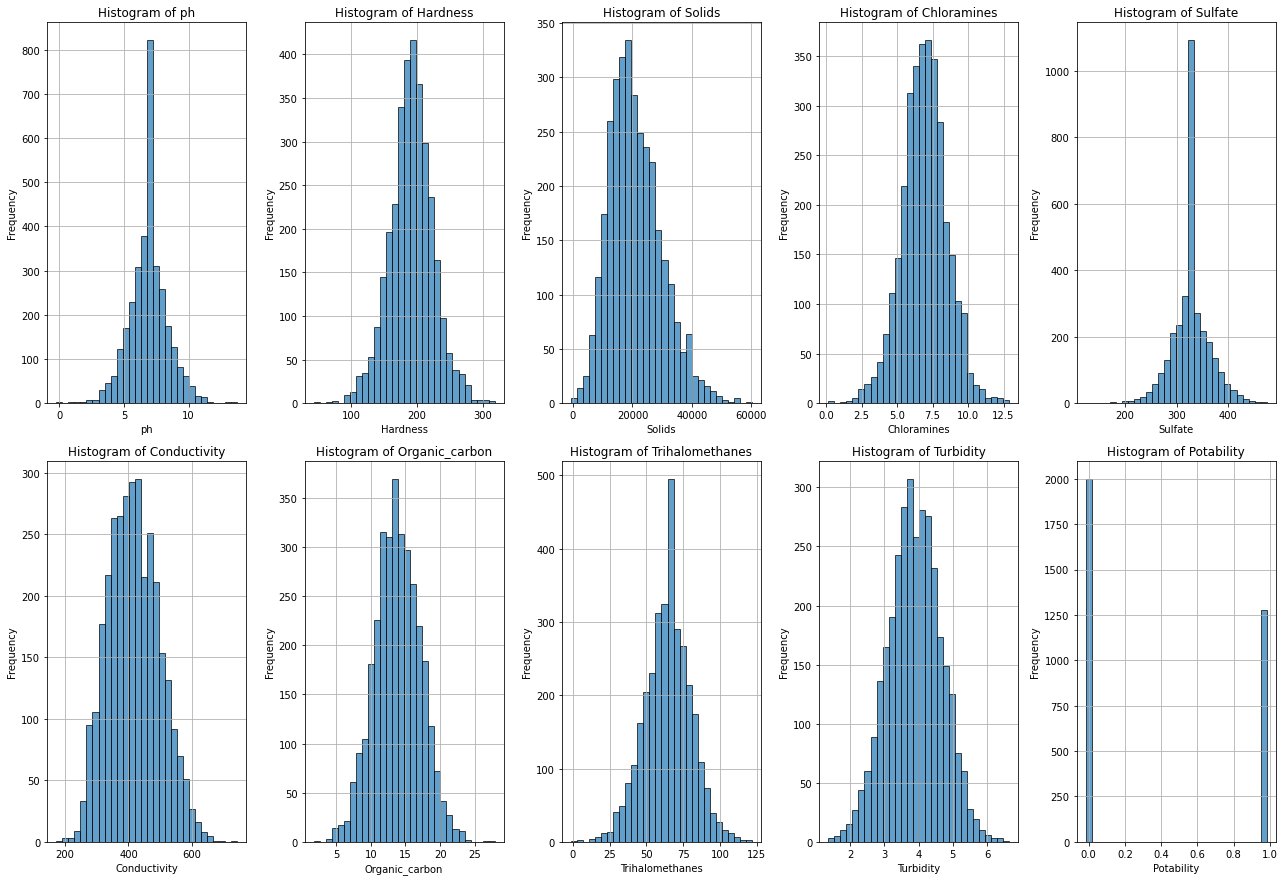

In [49]:

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 18))
axes = axes.flatten()

for idx, column in enumerate(columns_to_plot):

    df_clean = df_filled_3.select(col(column).cast("float"))

    histogram_data = df_clean.rdd.flatMap(lambda x: x).histogram(30)
    bins = histogram_data[0]
    counts = histogram_data[1]

    axes[idx].bar(bins[:-1], counts, width=bins[1] - bins[0], edgecolor='k', alpha=0.7)
    axes[idx].set_title(f'Histogram of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Deal with outliers

In [54]:
from pyspark.sql.functions import stddev
from pyspark.sql.types import DoubleType

z_score_threshold = 3

def calculate_z_scores_and_filter(df, z_score_threshold):
    numeric_columns = [c for c, dtype in df.dtypes if dtype in ('int', 'double', 'float')]
    stats = df.select([mean(col(c)).alias(c + '_mean') for c in numeric_columns] + 
                      [stddev(col(c)).alias(c + '_stddev') for c in numeric_columns]).collect()[0]
    
    z_score_cols = [(col(c) - stats[c + '_mean']) / stats[c + '_stddev'] for c in numeric_columns]
    for i, c in enumerate(numeric_columns):
        df = df.withColumn(c + '_z', z_score_cols[i])
    
    condition = ' or '.join([f"abs({c}_z) > {z_score_threshold}" for c in numeric_columns])
    df_no_outliers = df.filter(f"not ({condition})")

    z_score_columns = [c + '_z' for c in numeric_columns]
    df_no_outliers = df_no_outliers.drop(*z_score_columns)
    
    return df_no_outliers

df_no_outliers = calculate_z_scores_and_filter(df_filled_3, z_score_threshold)
df_no_outliers.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862| 333.7757766108134| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|8.099124189298397|224.23625939355776|19909.541732292393|9.275883602694089| 333.7757766108

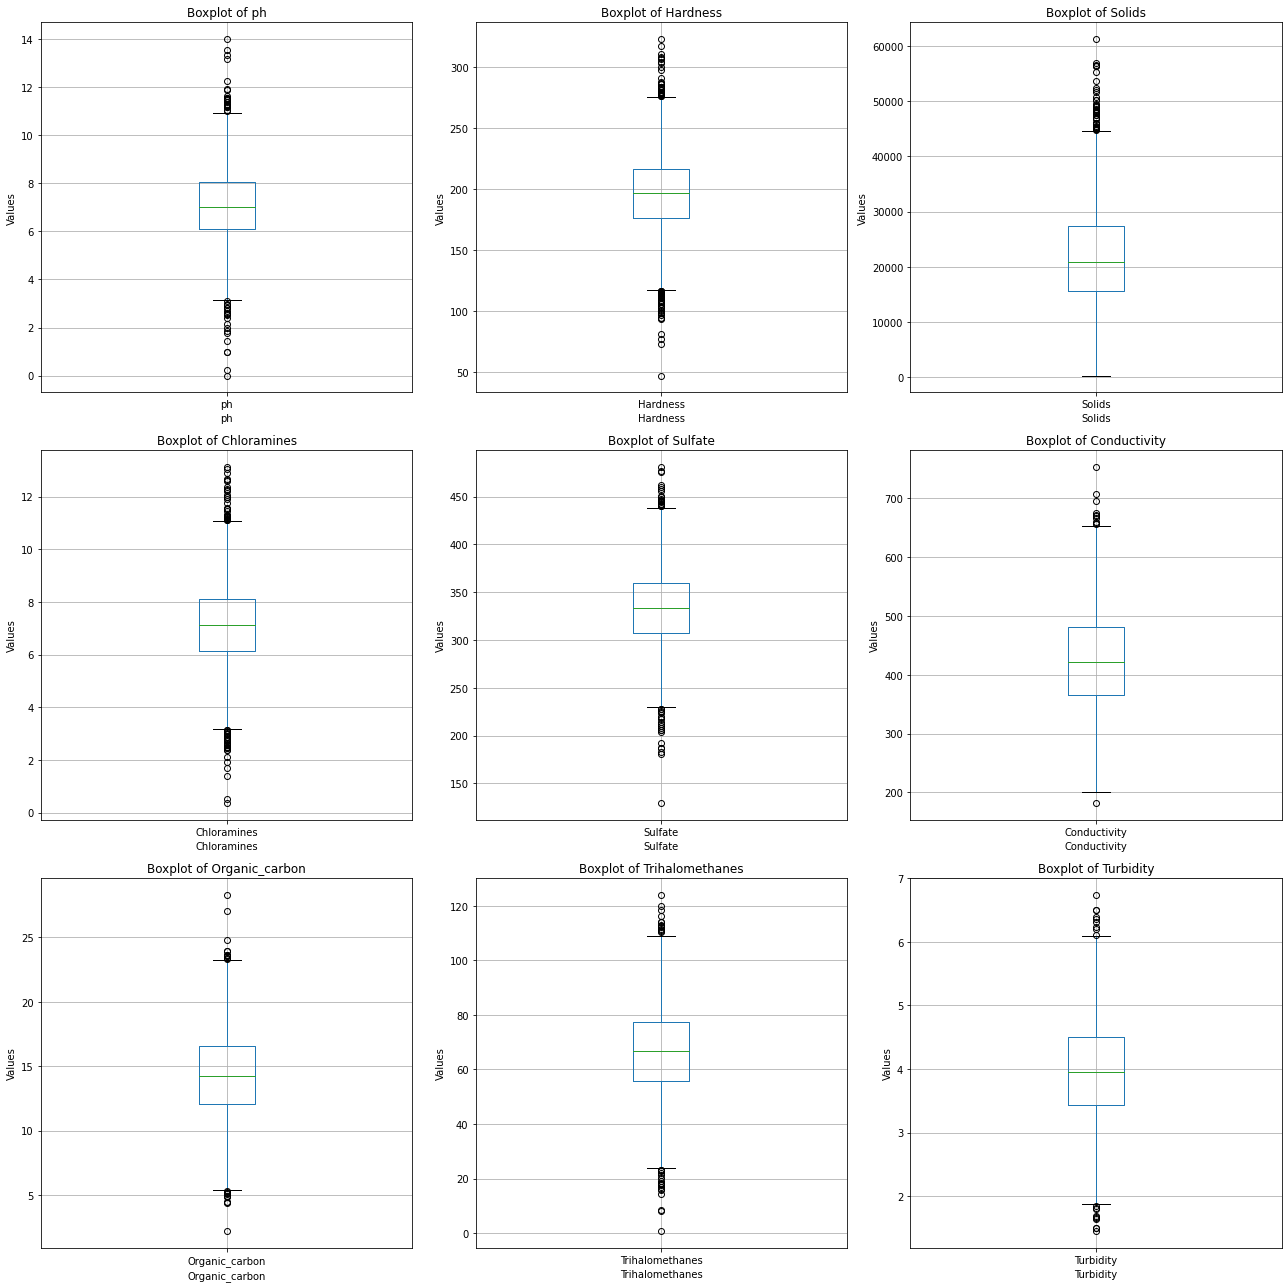

In [57]:
df_clean = df_no_outliers.select([col(column).cast("float") for column in columns_to_plot2])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

axes = axes.flatten()

for idx, column in enumerate(columns_to_plot2):
    pandas_df.boxplot(column=column, ax =axes[idx])

    axes[idx].set_title(f'Boxplot of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Values')
    axes[idx].grid(True)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Constructing a New Feature

In [59]:
df_new = df_no_outliers.withColumn("pH_Category", 
    when(col("ph") < 5.0, "Very Acidic")
    .when((col("ph") >= 5.0) & (col("ph") < 6.5), "Acidic")
    .when((col("ph") >= 6.5) & (col("ph") < 7.0), "Slightly Acidic")
    .when((col("ph") >= 7.0) & (col("ph") <= 7.5), "Neutral")
    .when((col("ph") > 7.5) & (col("ph") <= 8.0), "Slightly Alkaline")
    .when((col("ph") > 8.0) & (col("ph") < 9.0), "Alkaline")
    .otherwise("Extremely Alkaline")
)

# Show the DataFrame with the new column
df_new.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|       pH_Category|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|           Neutral|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862| 333.7757766108134| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|       Very Aci

# Data Integration

In [61]:
# Split the DataFrame into two parts
split_ratio = [0.5, 0.5]  # 50% split
df_1, df_2 = df_new.randomSplit(split_ratio, seed=42)

df_merged = df_1.union(df_2)

df_merged.show(5)

+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+----------+-----------+
|                ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|  Trihalomethanes|         Turbidity|Potability|pH_Category|
+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+----------+-----------+
|2.9454690611226875|126.74810032577287|16829.393039119645|10.59739483099463| 333.7757766108134|456.23318950350614| 10.15713862348548|79.31055731576916|  5.06998277048037|         0|Very Acidic|
|3.2309731059187423|120.78544948310383|13691.094972435034|6.835951440246375|328.24028919650993| 261.4352151594753|18.406139020307307|54.85212343389985|3.2819205591698437|         0|Very Acidic|
| 3.388090610523891| 212.02894

In [63]:
# Split the DataFrame into two parts
df_part1 = df_new.select("ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Potability", "Trihalomethanes")
df_part2 = df_new.select("ph", "Conductivity", "Organic_carbon", "Turbidity", "pH_Category")

df_part1.createOrReplaceTempView("Table1")
df_part2.createOrReplaceTempView("Table2")

# SQL query to merge the tables
query = """
SELECT a.ph, a.Hardness, a.Solids, a.Chloramines, a.Sulfate, b.Conductivity, b.Organic_carbon, 
a.Trihalomethanes, b.Turbidity, a.Potability, b.pH_Category
FROM Table1 a
JOIN Table2 b ON a.ph = b.ph
"""


merged_df = spark.sql(query)
merged_df.show(5)

+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+----------------+------------------+----------+-----------+
|               ph|         Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon| Trihalomethanes|         Turbidity|Potability|pH_Category|
+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+----------------+------------------+----------+-----------+
|7.036752103833548|204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336|428.21398699299374| 8.668672182023442|86.9909704615088|3.6995580484850445|         0|    Neutral|
|7.036752103833548|204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 555.5485339351901|16.959268901127814|86.9909704615088|   4.3316909034515|         0|    Neutral|
|7.036752103833548|204.8904554713363|20791.31

# Formatting Data

In [64]:
df_new = df_new.withColumn("Potability_new", 
    when(col("Potability") == 1, "Potable")
    .when(col("Potability") == 0, "Not_Potable")
    .otherwise("Unknown"))

# Show the DataFrame
df_new.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+--------------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|       pH_Category|Potability_new|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+--------------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|           Neutral|   Not_Potable|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862| 333.7757766108134| 592.8853591348523|15.180013116357259| 56.

# Feature Selection

In [68]:
from pyspark.sql.functions import abs as abs_func
from pyspark.sql.types import IntegerType, DoubleType
target_col = "Potability"
numeric_columns = [col for col in df_new.columns if col != target_col and df_new.schema[col].dataType in [IntegerType(), DoubleType()]]

correlations = {}
for col in numeric_columns:
    correlation = df_new.stat.corr(col, target_col)
    correlations[col] = abs(correlation)

from pyspark.sql import Row
corr_df = spark.createDataFrame([Row(column=col, correlation=corr_value) for col, corr_value in correlations.items()])
corr_df.show()

+---------------+--------------------+
|         column|         correlation|
+---------------+--------------------+
|             ph|0.005879408251619147|
|       Hardness|0.011852030481255625|
|         Solids|0.020164056696870967|
|    Chloramines| 0.01516005230240678|
|        Sulfate|0.003729501493945...|
|   Conductivity| 0.00775028891851195|
| Organic_carbon|0.018548033749245792|
|Trihalomethanes|0.007510972033178...|
|      Turbidity|0.005080677923772...|
+---------------+--------------------+



In [76]:
lowest_corr_col

'Sulfate'

In [74]:
lowest_corr_col = min(correlations, key=correlations.get)
df_filtered = df_new.drop(lowest_corr_col)
df_filtered.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+----------+------------------+--------------+
|               ph|          Hardness|            Solids|      Chloramines|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|       pH_Category|Potability_new|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+----------+------------------+--------------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|           Neutral|   Not_Potable|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|       Very Acidic|   Not_Potable|
|8.099124189298

# Data Projection

In [75]:
from pyspark.sql.functions import skewness
skewness_values = df_filtered.select([skewness(col).alias(col) for col in df_filtered.columns])

skewness_values.show()

+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------+
|                 ph|            Hardness|             Solids|         Chloramines|      Conductivity|      Organic_carbon|     Trihalomethanes|           Turbidity|         Potability|pH_Category|Potability_new|
+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------+
|0.08908896878071942|-0.04833388407735...|0.47006352877103197|-0.06167515762439...|0.2246338043431364|-0.01392298742506...|-0.02756028593909...|-0.02445489843735...|0.48053954286493844|       null|          null|
+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+----